
## Class-Conditional Prototype-Based Classification: A Comparative Study of Decision Strategies

#### Sibo Zhang
#### Department of Civil, Architectural, and Environmental Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### What is Class-Conditional Prototype-Based Classification?

**Class-conditional prototype-based classification** is a two-stage classification approach that combines clustering and prototype-based decision-making. Prototypes are first learned separately within each class using unsupervised clustering (e.g., K-means), and classification is then performed based on distances between test samples and these prototypes. This approach preserves intra-class structure and enables flexible, interpretable decision rules.


### Executive Summary

Prototype-based classification methods are simple and interpretable, but their performance under class-conditional clustering strategies and across different decision mechanisms remains underexplored.

This project implements class-conditional K-means clustering and evaluates four classification strategies: nearest prototype, distance-weighted voting, KNN-based voting, and logistic regression on prototype distances.

Results show that soft decision methods—particularly logistic regression and distance-weighted classification—consistently yield higher accuracy and stability across different values of k.

We recommend adopting soft, distance-aware decision strategies for prototype-based classification when using class-conditional clustering, as they offer a strong balance between interpretability and predictive performance.


### Import Packages
Some standard packages should have been installed with Anaconda 3 to run this workflow.

In [1]:
# === Basic libraries ===
import pandas as pd                             # Tabular data manipulation
import numpy as np                              # Numerical computing with arrays
import warnings                                 # Control warning display
import matplotlib                               # Base matplotlib interface
import matplotlib.pyplot as plt                 # Plotting interface
import matplotlib.patheffects as path_effects   # Visual effects for plots
import os                                       # OS-level file operations
os.environ["OMP_NUM_THREADS"] = "1"             # Suppress MKL thread warning on some Windows setups

# === Scikit-learn: preprocessing, modeling, and evaluation ===
from sklearn.preprocessing import StandardScaler              # feature standardization
from sklearn.model_selection import train_test_split          # train/test split
from sklearn.cluster import KMeans                            # K-means clustering
from scipy.spatial.distance import cdist                      # compute pairwise distances
from sklearn.metrics import (classification_report,           # classification summary
                             accuracy_score,                  # prediction accuracy
                             confusion_matrix,                # confusion matrix
                             ConfusionMatrixDisplay)          # confusion matrix visualization
from sklearn.neighbors import NearestNeighbors                # K-nearest neighbors search
from sklearn.linear_model import LogisticRegression           # logistic regression classifier

### Functions

The following functions will be used in the workflow.

In [2]:
# Plot function to visualize individual facies groups in Porosity vs AI space
def plot_facies_scatter(X, facies_mask, ax, color, label, title, xlim=None, ylim=None):
    """
    Plot a scatter plot for a single facies group on the given Axes object.
    Parameters:
    - X           : ndarray of shape (n_samples, 2), standardized [Porosity, AI]
    - facies_mask : boolean mask to filter data for the specific facies
    - ax          : matplotlib Axes object to draw the plot on
    - color       : color of the scatter points
    - label       : label for the plotted points (used in the legend)
    - title       : title of the subplot
    - xlim        : optional tuple of x-axis limits (xmin, xmax)
    - ylim        : optional tuple of y-axis limits (ymin, ymax)
    """
    ax.scatter(X[facies_mask, 0], X[facies_mask, 1], c=color, alpha=0.7, label=label)    # draw scatter points
    ax.set_title(title)                                         # set subplot title
    ax.set_xlabel("Porosity")                                   # label x-axis
    ax.set_ylabel("Acoustic Impedance")                         # label y-axis
    ax.legend()                                                 # display legend
    ax.grid(True)                                               # enable grid
    if xlim:
        ax.set_xlim(xlim)                                       # apply x-axis limits if provided
    if ylim:
        ax.set_ylim(ylim)                                       # apply y-axis limits if provided
    ax.tick_params(axis='y', labelsize=9)                       # show y-axis ticks
    return

# Utility function to compute axis limits with padding (used for consistent plot scaling)
def get_limits(X):
    """
    Compute x and y axis limits with 5% padding for 2D scatter plots.
    Parameters:
    - X : ndarray of shape (n_samples, 2), where columns represent Porosity and AI
    Returns:
    - xlim : tuple, (xmin, xmax) with padding applied
    - ylim : tuple, (ymin, ymax) with padding applied
    """
    x_pad = 0.05 * (X[:, 0].max() - X[:, 0].min())       # 5% padding in x direction
    y_pad = 0.05 * (X[:, 1].max() - X[:, 1].min())       # 5% padding in y direction
    xlim = (X[:, 0].min() - x_pad, X[:, 0].max() + x_pad)  # padded x limits
    ylim = (X[:, 1].min() - y_pad, X[:, 1].max() + y_pad)  # padded y limits
    return xlim, ylim

# Plot function to visualize confusion matrix heatmap on a given axes object
# Adapted from: https://github.com/scikit-learn/scikit-learn/blob/main/examples/model_selection/plot_confusion_matrix.py
# The original code was modified to support embedded plotting
def plot_confusion_matrix(cm, accuracy, ax):
    """
    Plot a confusion matrix heatmap using scikit-learn's ConfusionMatrixDisplay.

    Parameters:
    - cm : ndarray
        Confusion matrix values (e.g., 2x2 for binary classification)
    - accuracy : float
        Overall classification accuracy to include in the title
    - ax : matplotlib Axes
        Axes object to draw the matrix on
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Facies 0', 'Facies 1'])
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)                      # draw confusion matrix
    ax.set_title(f"Confusion Matrix\nAccuracy = {accuracy:.4f}")             # title with accuracy
    ax.grid(False)                                                           # hide grid lines


### Load Data

The following workflow applies the .csv file `sample_data_MV_biased.csv`. The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets/blob/master/sample_data_MV_biased.csv)  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **AI (acoustic impedence)** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$

In [3]:
# Load data from GeoDataSets GitHub repository  
url = "https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv"
df = pd.read_csv(url)                                # read CSV from URL
df = df[['Facies', 'Porosity', 'AI']]                # Keep only selected columns (Facies, Porosity, AI)

### Class-Conditional Prototype-Based Classification: A Comparative Study of Decision Strategies

This workflow presents a structured pipeline for class-conditional prototype-based classification.  

We begin with **data preparation and visualization**, including standardization and outlier removal.  

Next, we apply **class-conditional clustering** to the training data using K-means, ensuring that each class is independently represented by multiple prototypes.  

We then perform **prototype-based classification and evaluation** using four decision strategies, comparing their predictive performance and interpretability.  

Finally, we conduct **hyperparameter tuning** to assess the sensitivity of each method to the number of clusters per class.


### 1. Data Preparation and Visualization

In this step, we load the dataset from a public geostatistics repository, select key features (Facies, Porosity, and AI), and perform data cleaning by removing outliers using the IQR method. We then standardize the input features. Finally, we visualize the class distribution and feature separability using bar plots, boxplots, and scatter plots. These visualizations help us understand class imbalance and distinguishable trends between facies in the 2D feature space.

#### 1.1 Data Overview and Preprocessing

First, let’s look at the statistics of the data.

In [4]:
df.describe().transpose()                                     # summary statistics for the DataFrame

,count,mean,std,min,25%,50%,75%,max
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


Then we perform feature selection and standardization on the data.

In [5]:
features = ['Porosity', 'AI']                   # select two features for analysis
X_raw = df[features].values                     # extract raw feature matrix
y = df['Facies'].values                         # extract labels: facies 0 or 1

scaler = StandardScaler()                       # initialize standard scaler
X_scaled = scaler.fit_transform(X_raw)          # apply standardization (mean=0, std=1)

Next, we visualizes the distribution of facies labels and summarizes the spread of the standardized features.

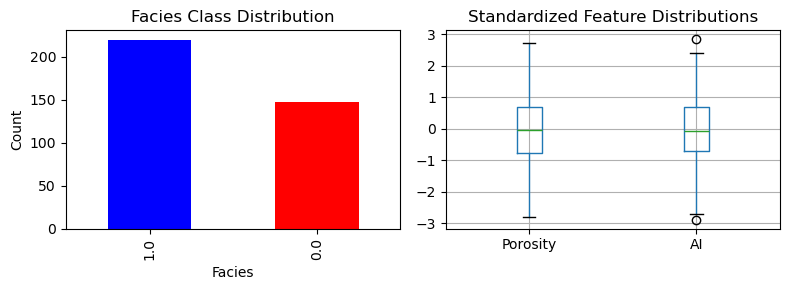

In [6]:
plt.figure(figsize=(8, 3))                                # set up side-by-side plots
df_classes = df['Facies'].value_counts()                  # count samples per facies class

# Left plot: class distribution (Facies 0 vs. 1)
plt.subplot(1, 2, 1)
df_classes.plot(kind='bar', color=['b', 'r'])             # bar plot for class distribution
plt.title("Facies Class Distribution")                    
plt.xlabel("Facies")                                     
plt.ylabel("Count")                                       

# Right plot: boxplot of standardized features
plt.subplot(1, 2, 2)
pd.DataFrame(X_scaled, columns=features).boxplot()        # box plot of standardized features
plt.title("Standardized Feature Distributions")           

plt.tight_layout()
plt.show()                                                # display both plots


#### 1.2 Outlier Removal

The boxplot on the right in the previous figure shows that Acoustic Impedance (AI) contain potential outliers (points beyond the whiskers), which could negatively impact clustering and classification performance.

To address this, we apply Interquartile Range (IQR) filtering to remove extreme values:

In [7]:
Q1 = df[["Porosity", "AI"]].quantile(0.25)                       # 25th percentile for each feature
Q3 = df[["Porosity", "AI"]].quantile(0.75)                       # 75th percentile
IQR = Q3 - Q1                                                    # interquartile range
# Define mask for non-outliers: True = keep the row
mask = ~((df[["Porosity", "AI"]] < (Q1 - 1.5 * IQR)) | (df[["Porosity", "AI"]] > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask].reset_index(drop=True)                             # remove outliers and reset index

After filtering outliers, we repeat the earlier steps to examine the updated facies class distribution and standardized feature ranges.

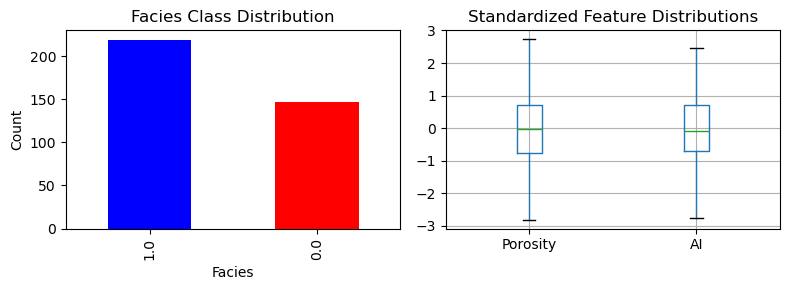

In [8]:
X_raw = df[features].values                         # extract raw feature matrix
y = df['Facies'].values                             # extract labels: facies 0 or 1

scaler = StandardScaler()                           # initialize standard scaler
X_scaled = scaler.fit_transform(X_raw)              # apply standardization (mean=0, std=1)

plt.figure(figsize=(8, 3))                          # set up side-by-side plots
df_classes = df['Facies'].value_counts()            # count samples per facies class

plt.subplot(1, 2, 1)
df_classes.plot(kind='bar', color=['b', 'r'])       # bar plot for class distribution
plt.title("Facies Class Distribution")
plt.xlabel("Facies")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
pd.DataFrame(X_scaled, columns=features).boxplot()  # box plot of standardized features
plt.title("Standardized Feature Distributions")
plt.tight_layout()
plt.show()


#### 1.3 Data Visualization

We visualize the distribution of the two standardized features, Porosity and Acoustic Impedance, for each facies group, as well as both combined.

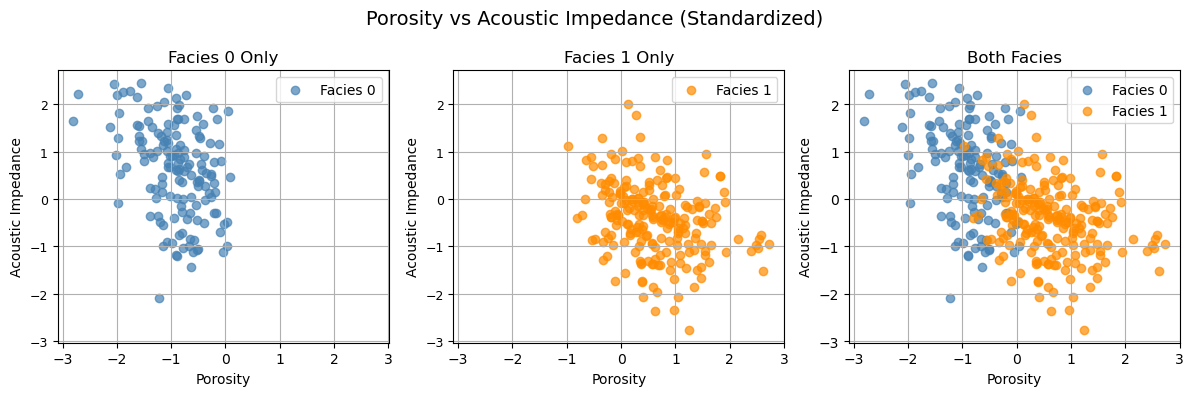

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)           # create a 1x3 subplot

mask_0 = y == 0                                                        # boolean mask for Facies 0
mask_1 = y == 1                                                        # boolean mask for Facies 1
xlim_std, ylim_std = get_limits(X_scaled)                              # compute consistent axis limits with padding

# Left: Facies 0 only
plot_facies_scatter(X_scaled, mask_0, axes[0], 'steelblue', 'Facies 0', 'Facies 0 Only', xlim=xlim_std, ylim=ylim_std)
# Middle: Facies 1 only
plot_facies_scatter(X_scaled, mask_1, axes[1], 'darkorange', 'Facies 1', 'Facies 1 Only', xlim=xlim_std, ylim=ylim_std)
# Right: Both facies overlaid
axes[2].scatter(X_scaled[mask_0, 0], X_scaled[mask_0, 1], c='steelblue', alpha=0.7, label='Facies 0')
axes[2].scatter(X_scaled[mask_1, 0], X_scaled[mask_1, 1], c='darkorange', alpha=0.7, label='Facies 1')
axes[2].set_title("Both Facies")
axes[2].set_xlabel("Porosity")
axes[2].set_ylabel("Acoustic Impedance")
axes[2].set_xlim(xlim_std)
axes[2].set_ylim(ylim_std)
axes[2].legend()
axes[2].grid(True)

# Ensure all y-axis tick labels are shown
for ax in axes:
    ax.yaxis.set_tick_params(labelleft=True)

plt.suptitle("Porosity vs Acoustic Impedance (Standardized)", fontsize=14)
plt.tight_layout()
plt.show()


From the figure we can see that Facies 0 and Facies 1 exhibit noticeable separation in the standardized Porosity–AI space, suggesting that classification based on these two features is feasible.

### 2. Class-Conditional Clustering of Training Data

In this step, we split the dataset into training and test sets while preserving the class distribution. We then apply K-means clustering independently within each facies class, allowing us to obtain class-conditional prototypes. These prototypes will later serve as anchors for various classification methods. Finally, we visualize the clustering outcome to confirm the intra-class cluster separability in the Porosity–AI space.

#### 2.1 Train-Test Split

We divide the dataset into training and testing sets, 30% of the data is reserved for testing.

In [10]:
# Split the standardized data into train and test sets, preserving class balance
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.3, random_state=42, stratify=y )
# Display shapes of resulting splits
X_train.shape, X_test.shape

((256, 2), (110, 2))

#### 2.2 Class-Conditional Clustering

We apply K-Means clustering separately on each facies class in the training set to identify class-specific prototypes. These prototypes will be used in downstream classification tasks.

In [11]:
# Split training data by facies
X0 = X_train[y_train == 0]            # samples labeled as Facies 0
X1 = X_train[y_train == 1]            # samples labeled as Facies 1

# Set number of clusters (per class) and random seed
k = 3
random_state = 42

# Apply KMeans clustering separately on each facies
kmeans0 = KMeans(n_clusters=k, random_state=random_state).fit(X0)  # cluster Facies 0
kmeans1 = KMeans(n_clusters=k, random_state=random_state).fit(X1)  # cluster Facies 1


#### 2.3 Visualize Class-Conditional Clusters

We visualize the result of class-conditional K-means clustering on the training set. Each facies is clustered independently, with prototypes (centroids) marked as stars.

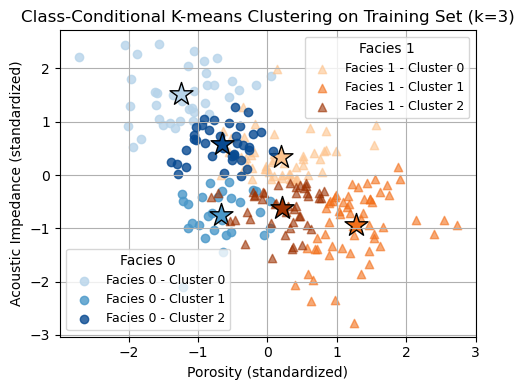

In [12]:
plt.figure(figsize=(5, 4))
ax = plt.gca()  # get current Axes instance

# Get cluster labels and centers
labels0 = kmeans0.labels_                       # cluster assignment for Facies 0
labels1 = kmeans1.labels_                       # cluster assignment for Facies 1
centers0 = kmeans0.cluster_centers_             # centroids for Facies 0
centers1 = kmeans1.cluster_centers_             # centroids for Facies 1

# Prepare custom colormaps and markers
cool_cmap = matplotlib.colormaps.get_cmap('Blues')
warm_cmap = matplotlib.colormaps.get_cmap('Oranges')
cold_colors = [cool_cmap(i) for i in np.linspace(0.3, 0.9, k)]
warm_colors = [warm_cmap(i) for i in np.linspace(0.3, 0.9, k)]
cold_marker = 'o'
warm_marker = '^'

# Plot clusters and centroids
handles_0, labels_0 = [], []
handles_1, labels_1 = [], []

for i in range(k):
    # Facies 0
    h0 = ax.scatter(X0[labels0 == i, 0], X0[labels0 == i, 1],
                    color=cold_colors[i], alpha=0.8, label=f"Facies 0 - Cluster {i}", marker=cold_marker)
    ax.scatter(centers0[i, 0], centers0[i, 1], color=cold_colors[i], marker='*', s=300, edgecolor='black')

    # Facies 1
    h1 = ax.scatter(X1[labels1 == i, 0], X1[labels1 == i, 1],
                    color=warm_colors[i], alpha=0.6, label=f"Facies 1 - Cluster {i}", marker=warm_marker)
    ax.scatter(centers1[i, 0], centers1[i, 1], color=warm_colors[i], marker='*', s=300, edgecolor='black')

    handles_0.append(h0)
    labels_0.append(f"Facies 0 - Cluster {i}")
    handles_1.append(h1)
    labels_1.append(f"Facies 1 - Cluster {i}")

# Add dual legends for each facies group
legend1 = ax.legend(handles_0, labels_0, loc='lower left', title='Facies 0', fontsize=9)
legend2 = ax.legend(handles_1, labels_1, loc='upper right', title='Facies 1', fontsize=9)
ax.add_artist(legend1)  # add the first legend back manually

# Final plot settings
ax.set_xlabel("Porosity (standardized)")
ax.set_ylabel("Acoustic Impedance (standardized)")
ax.set_title(f"Class-Conditional K-means Clustering on Training Set (k={k})")
ax.grid(True)
plt.tight_layout()
plt.show()


### 3. Prototype-Based Classification and Evaluation

In this step, class-conditional K-means clustering is used to generate prototype centers for each facies. Multiple prototype-based classification methods are then applied to the test set, including Nearest Prototype, Distance-Weighted Voting, KNN-Based Voting, and Logistic Regression on prototype distances. Performance is evaluated using confusion matrices, accuracy metrics, and prediction visualizations.

#### 3.1 Constructing Class Prototypes

We now consolidate the cluster centroids obtained from class-conditional K-means into a unified set of prototypes. These representative points are assigned binary class labels (0 for Facies 0, 1 for Facies 1), and will be used to drive the subsequent prototype-based classification.

In [13]:
# Combine cluster centers from both classes into a single prototype set
prototypes = np.vstack([kmeans0.cluster_centers_, kmeans1.cluster_centers_])             # shape: (2k, 2)

# Create a label array indicating which class each prototype belongs to
prototype_labels = np.array([0] * k + [1] * k)                                           # first k are class 0, next k are class 1

#### 3.2 Prototype-Based Classification (4 Methods)

We apply **four prototype-based classification methods** on the test set using the class-conditional cluster centers as prototypes:

1. **Nearest Prototype**: Assigns each test point to the class of the closest prototype based on Euclidean distance.
2. **Distance Weighted Voting**: Uses inverse distances to all prototypes as weights to compute class scores.
3. **KNN Weighted Voting**: Applies weighted voting based on the `k` nearest prototypes, where closer prototypes have more influence.
4. **Logistic Regression**: Trains a classifier using the distances to all prototypes as features.

Each method's prediction results, accuracy, and confusion matrix are saved in a dictionary for further evaluation and visualization.

In [14]:
# List of method names for reference and reporting
method_names = ["Nearest Prototype", "Distance Weighted", "KNN Weighted Voting", "Logistic Regression"]

method_results = {}        # Dictionary to store predictions, accuracy, and confusion matrix
k_vote = 3                 # Hyperparameter for Method 3 (K nearest prototypes)

# --- Method 1: Nearest Prototype ---
distances = cdist(X_test, prototypes)                               # distance matrix (test x prototypes)
y_pred = prototype_labels[np.argmin(distances, axis=1)]             # classify by nearest prototype
method_results[1] = ( y_pred, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred) )

# --- Method 2: Distance Weighted Voting ---
weights = 1 / (distances + 1e-8)                                     # inverse distance as weights
scores = [np.sum(weights[:, prototype_labels == cls], axis=1) for cls in [0, 1]]  # aggregated class scores
y_pred = np.argmax(scores, axis=0)                                   # assign class with higher score
method_results[2] = ( y_pred, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred) )

# --- Method 3: K-Nearest Prototype Voting ---
k_vote = min(3, 2 * k)                                               # ensure k_vote does not exceed prototype count
nbrs = NearestNeighbors(n_neighbors=min(k_vote, len(prototypes))).fit(prototypes)
distances_knn, indices = nbrs.kneighbors(X_test)
distances_knn = np.where(distances_knn == 0, 1e-8, distances_knn)    # avoid division by zero
y_pred = []
for i in range(len(X_test)):
    w = 1.0 / distances_knn[i]                                       # inverse distance weights
    neighbor_labels = prototype_labels[indices[i]]                   # get neighbor labels
    pred = 0 if np.sum(w[neighbor_labels == 0]) > np.sum(w[neighbor_labels == 1]) else 1
    y_pred.append(pred)
y_pred = np.array(y_pred)
method_results[3] = ( y_pred, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred) )

# --- Method 4: Logistic Regression on Distances to Prototypes ---
X_train_feat = cdist(X_train, prototypes)                            # train features = distances to prototypes
X_test_feat = cdist(X_test, prototypes)
clf = LogisticRegression(random_state=42).fit(X_train_feat, y_train) # train classifier
y_pred = clf.predict(X_test_feat)                                    # predict using learned model
method_results[4] = ( y_pred, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred) )


#### 3.3 Classification Performance Visualization

This step visualizes the classification performance of each method using **confusion matrices**. Each subplot displays the confusion matrix for one of the four prototype-based methods, along with its corresponding accuracy score.

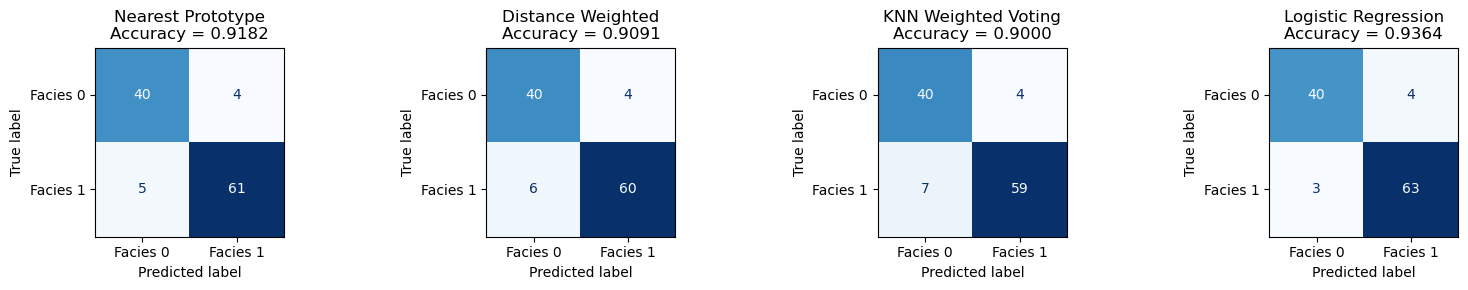

In [15]:
# Plot confusion matrices for all methods stored in method_results
fig, axes = plt.subplots(1, 4, figsize=(16, 3))     # create 1-row 4-column layout

for ax, method_id, title in zip(axes, range(1, 5), method_names):
    y_pred, acc, cm = method_results[method_id]     # unpack prediction, accuracy, confusion matrix
    plot_confusion_matrix(cm, acc, ax=ax)           # plot confusion matrix using helper function
    ax.set_title(f"{title}\nAccuracy = {acc:.4f}")  # set subplot title with accuracy
    ax.grid(False)                                  # disable grid

plt.tight_layout()
plt.show()


For each classification method, we output a detailed **classification report** including precision, recall, F1-score, and support for both facies classes.

In [16]:
# Print classification report for each method
for method_id, (y_pred, _, _) in method_results.items():
    method_name = method_names[method_id - 1]                 # list index starts from 0
    print(f"\n=== Method {method_id}: {method_name} ===")
    print(classification_report(y_test, y_pred, target_names=['Facies 0', 'Facies 1']))



=== Method 1: Nearest Prototype ===
              precision    recall  f1-score   support

    Facies 0       0.89      0.91      0.90        44
    Facies 1       0.94      0.92      0.93        66

    accuracy                           0.92       110
   macro avg       0.91      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110


=== Method 2: Distance Weighted ===
              precision    recall  f1-score   support

    Facies 0       0.87      0.91      0.89        44
    Facies 1       0.94      0.91      0.92        66

    accuracy                           0.91       110
   macro avg       0.90      0.91      0.91       110
weighted avg       0.91      0.91      0.91       110


=== Method 3: KNN Weighted Voting ===
              precision    recall  f1-score   support

    Facies 0       0.85      0.91      0.88        44
    Facies 1       0.94      0.89      0.91        66

    accuracy                           0.90       110
   macro avg   

**Prediction Outcome Visualization**: This panel compares the prediction results of four classification methods. Each subplot shows correctly and incorrectly classified samples in the Porosity–Acoustic Impedance space, along with prototype locations. Circles denote correct predictions, crosses indicate incorrect predictions, and stars represent class-specific prototype centers.

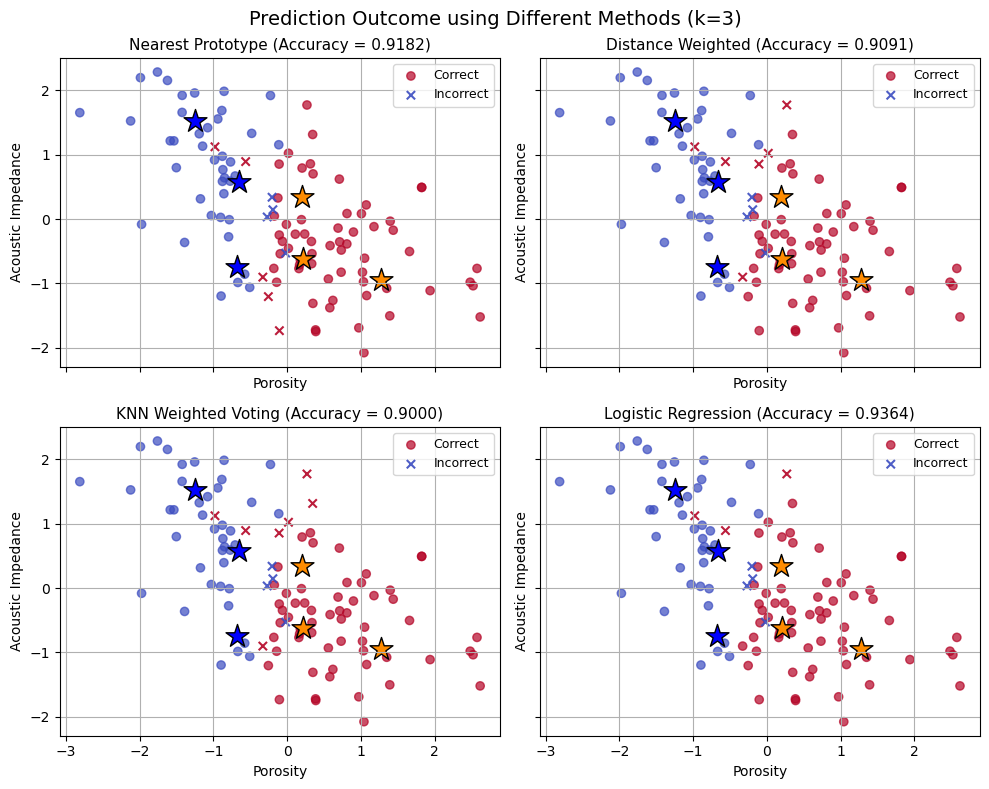

In [17]:
# Plot prediction outcomes for all 4 classification methods
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)  # create 2x2 grid of subplots
axes = axes.ravel()  # flatten to a 1D list for easy indexing

for idx, (method_id, (y_pred, _, _)) in enumerate(method_results.items()):
    ax = axes[idx]
    method_name = method_names[method_id - 1]            # get method name from list
    y_pred, acc, cm = method_results[method_id]          # unpack prediction, accuracy, confusion matrix

    # Create masks for correct and incorrect predictions
    correct = y_test == y_pred                           # correct predictions
    incorrect = ~correct                                 # incorrect predictions

    # Plot correctly predicted samples (circles)
    ax.scatter(X_test[correct, 0], X_test[correct, 1],
               c=y_test[correct], cmap='coolwarm', marker='o', alpha=0.7, label='Correct')

    # Plot incorrectly predicted samples (crosses)
    ax.scatter(X_test[incorrect, 0], X_test[incorrect, 1],
               c=y_test[incorrect], cmap='coolwarm', marker='x', alpha=0.9, label='Incorrect')

    # Plot prototype points (stars)
    for i in range(len(prototypes)):
        color = 'blue' if prototype_labels[i] == 0 else 'darkorange'
        ax.scatter(prototypes[i, 0], prototypes[i, 1],
                   marker='*', s=300, c=color, edgecolor='black')

    # Set titles and axis labels
    ax.set_title(f"{method_name} (Accuracy = {acc:.4f})", fontsize=11)
    ax.set_xlabel("Porosity")
    ax.set_ylabel("Acoustic Impedance")
    ax.grid(True)
    ax.legend(fontsize=9)

# Add a global title and layout adjustment
plt.suptitle(f"Prediction Outcome using Different Methods (k={k})", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


### 4. Hyperparameter Tuning — Number of Clusters per Class

This step explores the impact of the number of clusters per class (k) on classification performance. For each k from 1 to 12, class-conditional K-means clustering is performed, and four prototype-based classification methods are applied. The test accuracy is tracked across methods and k values to assess model sensitivity and guide optimal hyperparameter selection. Final results are visualized in an accuracy–k line chart.

In [18]:
# Method names for display and indexing
method_names = ["Nearest Prototype", "Distance Weighted", "KNN Weighted Voting", "Logistic Regression"]

# Range of k values to test (number of clusters per class)
k_values = range(1, 13)

# Dictionary to store accuracy results for each method at each k
method_accuracies = {i + 1: [] for i in range(len(method_names))}  # keys: method IDs 1~4

# Main loop: iterate over each k value
for k in k_values:
    # Split training data by facies (label 0 and 1)
    X0 = X_train[y_train == 0]
    X1 = X_train[y_train == 1]

    # Perform class-conditional K-means clustering (k clusters per class)
    kmeans0 = KMeans(n_clusters=k, random_state=42).fit(X0)
    kmeans1 = KMeans(n_clusters=k, random_state=42).fit(X1)

    # Combine all prototype coordinates into a single array
    prototypes = np.vstack([kmeans0.cluster_centers_, kmeans1.cluster_centers_])

    # Generate corresponding labels for each prototype (0 for Facies 0, 1 for Facies 1)
    prototype_labels = np.array([0] * k + [1] * k)

    # Evaluate each classification method
    for method_id in range(1, 5):

        # --- Method 1: Nearest Prototype ---
        if method_id == 1:
            distances = cdist(X_test, prototypes)                          # compute test-to-prototype distances
            y_pred = prototype_labels[np.argmin(distances, axis=1)]        # assign class of closest prototype

        # --- Method 2: Distance Weighted Classification ---
        elif method_id == 2:
            distances = cdist(X_test, prototypes)
            weights = 1 / (distances + 1e-8)                               # inverse distance weighting
            scores = [np.sum(weights[:, prototype_labels == cls], axis=1) for cls in [0, 1]]
            y_pred = np.argmax(scores, axis=0)                             # predict class with highest total weight

        # --- Method 3: KNN with Inverse Distance Weighted Voting ---
        elif method_id == 3:
            k_vote = min(3, 2 * k)                                         # avoid k > number of prototypes
            nbrs = NearestNeighbors(n_neighbors=k_vote).fit(prototypes)
            distances, indices = nbrs.kneighbors(X_test)
            distances = np.where(distances == 0, 1e-8, distances)          # avoid division by zero

            y_pred = []  # collect predictions
            for i in range(len(X_test)):
                w = 1.0 / distances[i]                                     # inverse distance weights
                neighbor_labels = prototype_labels[indices[i]]             # labels of k nearest prototypes
                pred = 0 if np.sum(w[neighbor_labels == 0]) > np.sum(w[neighbor_labels == 1]) else 1
                y_pred.append(pred)
            y_pred = np.array(y_pred)

        # --- Method 4: Logistic Regression on Prototype Distances ---
        elif method_id == 4:
            X_train_feat = cdist(X_train, prototypes)                      # distance-based features for training
            X_test_feat = cdist(X_test, prototypes)                        # distance-based features for testing
            clf = LogisticRegression(random_state=42)
            clf.fit(X_train_feat, y_train)
            y_pred = clf.predict(X_test_feat)

        # Compute and store classification accuracy for current method and k
        acc = accuracy_score(y_test, y_pred)
        method_accuracies[method_id].append(acc)


This plot visualizes how test set accuracy varies with the number of clusters (k) used in class-conditional K-means clustering.

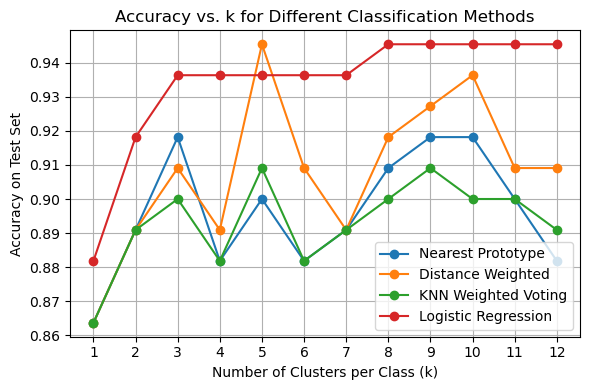

In [19]:
# Plotting the accuracy vs k curve for each method
plt.figure(figsize=(6, 4))
for method_id, acc_list in method_accuracies.items():
    plt.plot(k_values, acc_list, marker='o', label=method_names[method_id - 1])  # subtract 1 for correct name

plt.xticks(k_values)
plt.xlabel("Number of Clusters per Class (k)")
plt.ylabel("Accuracy on Test Set")
plt.title("Accuracy vs. k for Different Classification Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We extracts the best-performing k (number of clusters per class) for each classification method by selecting the maximum accuracy from the hyperparameter tuning results.

In [20]:
# Build a summary table of the best k and corresponding accuracy for each method
best_k_summary = []

# Loop through each method and its list of accuracies
for method_id, acc_list in method_accuracies.items():
    best_index = np.argmax(acc_list)                        # index of highest accuracy
    best_k = k_values[best_index]                           # corresponding k
    best_acc = acc_list[best_index]                         # best accuracy score
    best_k_summary.append({ 'Method': method_names[method_id - 1], 'Best k': best_k, 'Best Accuracy': round(best_acc, 4) })     # method_id starts from 1

# Convert results to a Pandas DataFrame for easy viewing
df_best_k = pd.DataFrame(best_k_summary)

# Display summary table
print(df_best_k)


                Method  Best k  Best Accuracy
0    Nearest Prototype       3         0.9182
1    Distance Weighted       5         0.9455
2  KNN Weighted Voting       5         0.9091
3  Logistic Regression       8         0.9455


### Results


We define a modular function `visualize_single_method_result(k, method_name)` that enables visual evaluation of any selected classification strategy under a given cluster count `k`.

Given a classification method (e.g., Nearest Prototype, Distance Weighted, etc.) and a clustering hyperparameter `k` (number of K-means clusters per class), the function produces a 3-panel diagnostic:

- **Prediction Outcome Plot:**  
  A 2D scatter plot of test samples in the standardized feature space. Correct and incorrect predictions are indicated with distinct markers, and prototype centers are displayed as stars colored by class.

- **Confusion Matrix:**  
  A heatmap showing the confusion matrix and the overall classification accuracy.

- **Classification Report:**  
  A textual summary of precision, recall, and F1-score for each class.

This design provides an intuitive and comprehensive way to evaluate how well a given classification strategy performs with different levels of granularity in the clustering step.

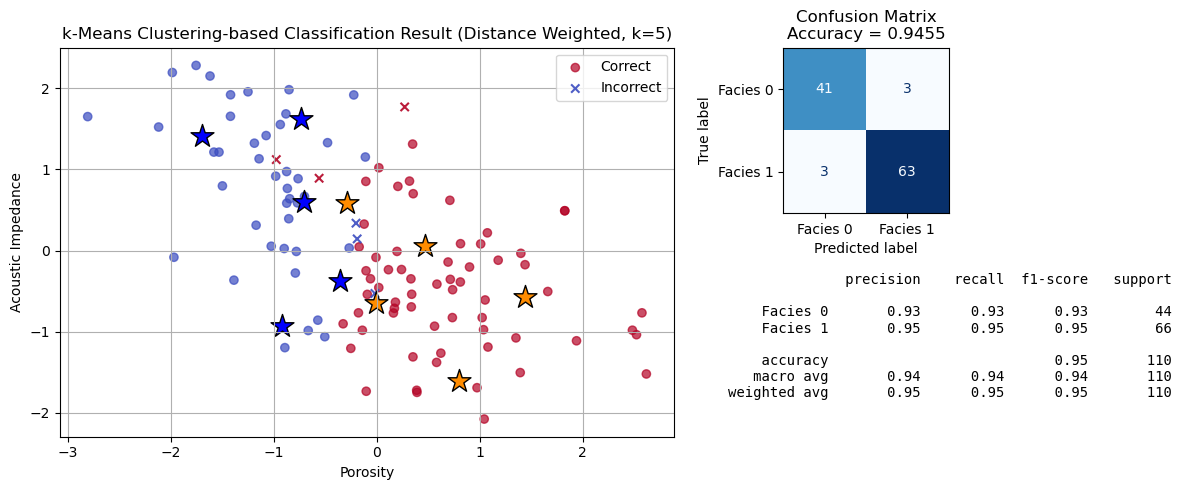

In [21]:
def visualize_single_method_result(k, method_name):
    # Step 1: Cluster training data class-conditionally to get prototypes
    X0 = X_train[y_train == 0]                                    # samples of class 0
    X1 = X_train[y_train == 1]                                    # samples of class 1
    kmeans0 = KMeans(n_clusters=k, random_state=42).fit(X0)       # K-means for Facies 0
    kmeans1 = KMeans(n_clusters=k, random_state=42).fit(X1)       # K-means for Facies 1
    prototypes = np.vstack([kmeans0.cluster_centers_,            # stack all cluster centers
                            kmeans1.cluster_centers_])
    prototype_labels = np.array([0] * k + [1] * k)                # assign class label to each prototype

    # Step 2: Predict test labels using the selected method
    if method_name == "Nearest Prototype":
        distances = cdist(X_test, prototypes)                     # compute distances to all prototypes
        y_pred = prototype_labels[np.argmin(distances, axis=1)]  # assign label of nearest prototype

    elif method_name == "Distance Weighted":
        distances = cdist(X_test, prototypes)
        weights = 1 / (distances + 1e-8)                          # inverse distance weights
        scores = [np.sum(weights[:, prototype_labels == cls], axis=1) for cls in [0, 1]]
        y_pred = np.argmax(scores, axis=0)                        # pick class with higher total weight

    elif method_name == "KNN Weighted Voting":
        k_vote = min(3, 2 * k)                                    # ensure k does not exceed prototype count
        nbrs = NearestNeighbors(n_neighbors=k_vote).fit(prototypes)
        distances_knn, indices = nbrs.kneighbors(X_test)
        distances_knn = np.where(distances_knn == 0, 1e-8, distances_knn)

        y_pred = []
        for i in range(len(X_test)):
            weights = 1.0 / distances_knn[i]                      # weight by inverse distance
            neighbor_labels = prototype_labels[indices[i]]        # labels of nearest prototypes
            pred = 0 if np.sum(weights[neighbor_labels == 0]) > np.sum(weights[neighbor_labels == 1]) else 1
            y_pred.append(pred)
        y_pred = np.array(y_pred)

    elif method_name == "Logistic Regression":
        X_train_feat = cdist(X_train, prototypes)                 # use prototype distances as features
        X_test_feat = cdist(X_test, prototypes)
        clf = LogisticRegression(random_state=42).fit(X_train_feat, y_train)
        y_pred = clf.predict(X_test_feat)

    else:
        raise ValueError("Invalid method name.")

    # Step 3: Visualization — outcome, confusion matrix, classification report
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(2, 3)

    ax_main = fig.add_subplot(gs[:, 0:2])                         # main prediction scatter
    ax_cm = fig.add_subplot(gs[0, 2])                             # confusion matrix
    ax_text = fig.add_subplot(gs[1, 2])                           # classification report text
    ax_text.axis('off')

    # Plot test prediction results (correct and incorrect)
    correct = y_test == y_pred
    incorrect = ~correct
    ax_main.scatter(X_test[correct, 0], X_test[correct, 1], c=y_test[correct], cmap='coolwarm', marker='o', alpha=0.7, label='Correct')
    ax_main.scatter(X_test[incorrect, 0], X_test[incorrect, 1], c=y_test[incorrect], cmap='coolwarm', marker='x', alpha=0.9, label='Incorrect')

    # Overlay prototype centers
    for i in range(len(prototypes)):
        color = 'blue' if prototype_labels[i] == 0 else 'darkorange'
        ax_main.scatter(prototypes[i, 0], prototypes[i, 1], marker='*', s=300, c=color, edgecolor='black')

    ax_main.set_xlabel("Porosity")
    ax_main.set_ylabel("Acoustic Impedance")
    ax_main.set_title(f"k-Means Clustering-based Classification Result ({method_name}, k={k})")
    ax_main.legend()
    ax_main.grid(True)

    # Confusion matrix plot
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, acc, ax=ax_cm)

    # Print classification report
    report_str = classification_report(y_test, y_pred, target_names=["Facies 0", "Facies 1"])
    ax_text.text(0.01, 0.99, report_str, fontsize=10, verticalalignment='top', family='monospace')

    plt.tight_layout()
    plt.show()


# Run for selected method and k
visualize_single_method_result(k=5, method_name="Distance Weighted")


To sum up, this project evaluated the classification performance of four decision strategies across a range of cluster counts per class (k = 1 to 12). Results show that logistic regression and distance-weighted methods consistently outperform nearest-prototype and KNN voting in terms of accuracy and stability. Visualization of confusion matrices and prediction outcomes further supports this finding, showing fewer misclassifications and clearer decision boundaries for the soft-decision methods. The best-performing configuration for each method was summarized in a comparison table, highlighting the optimal k values and associated accuracies.


### About the author

Sibo Zhang is a Ph.D. student in [Department of Civil, Architectural and Environmental Engineering](https://www.caee.utexas.edu/) at [The University of Texas at Austin](https://www.utexas.edu/).  

My research interests lie at the intersection of machine learning and architected metamaterials, with a focus on data-driven design, optimization, and classification of multistable structures.
This workflow reflects my ongoing effort to explore interpretable and modular classification strategies that can be extended to complex mechanical systems, such as classifying deformation modes or local responses in metamaterial lattices.  

I am actively seeking interdisciplinary collaborations that leverage machine learning to accelerate material discovery and structural innovation. I can be reached at sibo.zhang@utexas.edu.

*Sibo*

Sibo Zhang, Cockrell School of Engineering, The University of Texas at Austin

More Resources Available at: [GitHub](https://github.com/stevenzhang2150) | [GoogleScholar](https://scholar.google.com/citations?user=_MTGyowAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/sibo-zhang-36136b285/)

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)